In [1]:
import numpy as np
import matplotlib
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import matplotlib.pyplot as plt

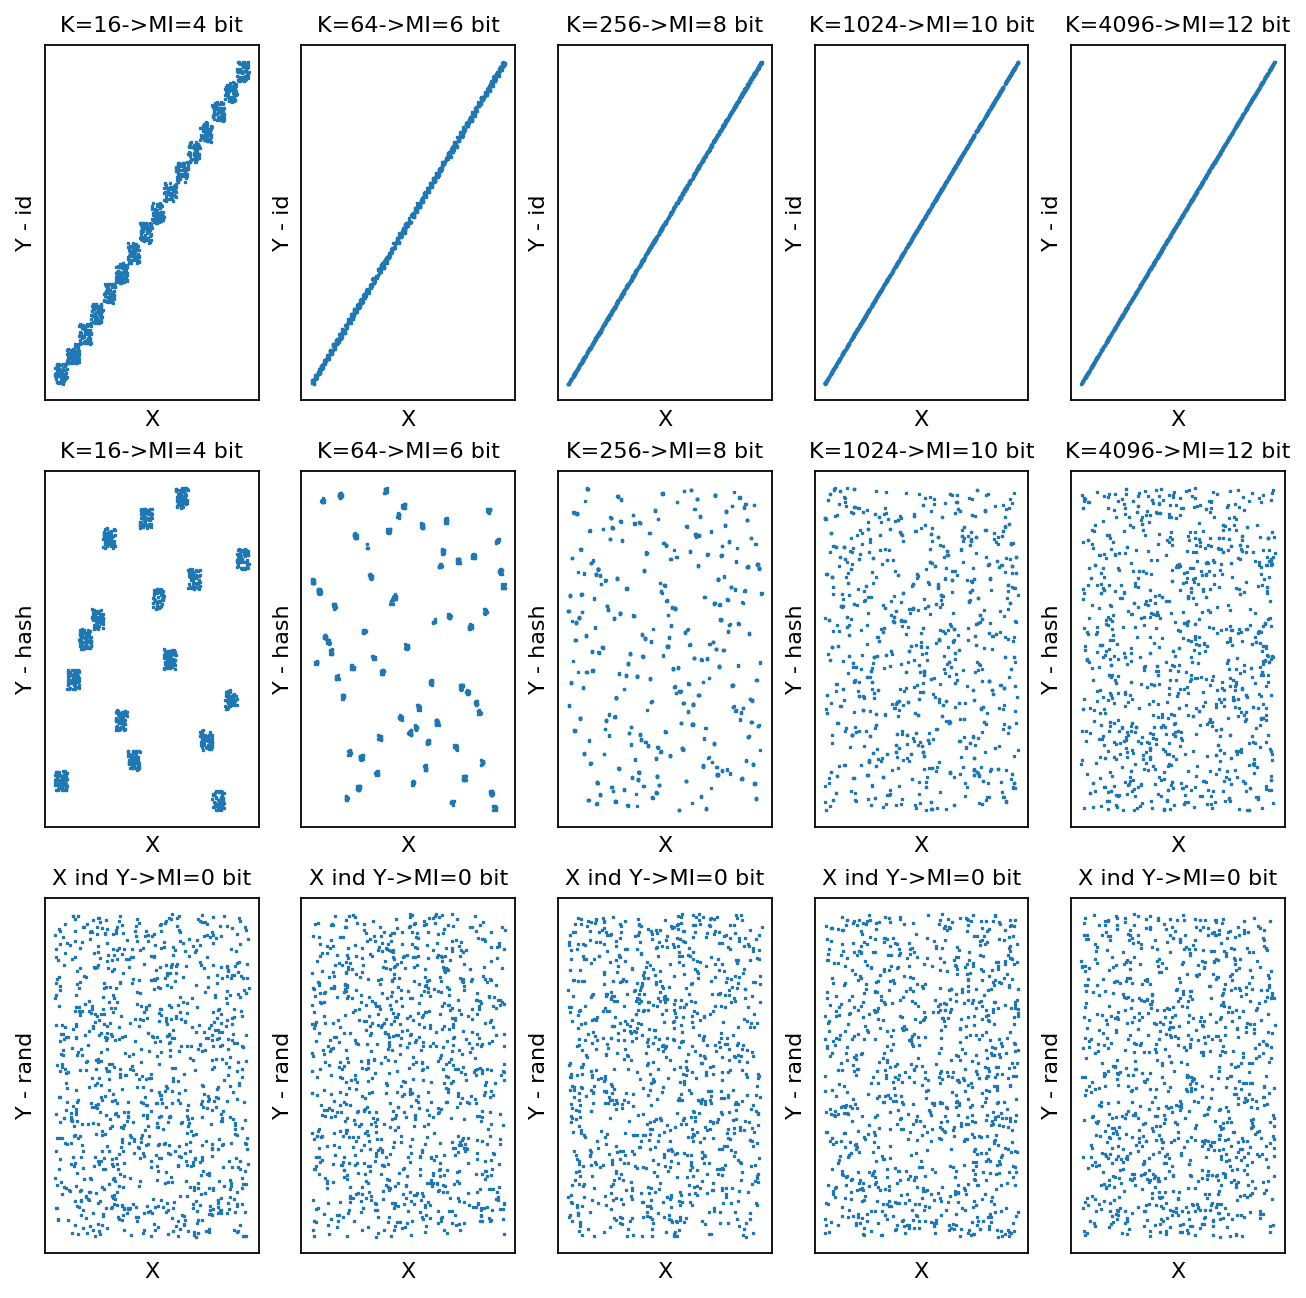

In [3]:
def permute(i):
    return i

modexp = np.frompyfunc(pow, 3, 1)

tables = {}
def hasher(i, k):
    if k not in tables:
        np.random.seed(0)
        tables[k] = np.arange(k)
        np.random.shuffle(tables[k])
    if (i>=k).any():
        print i, k
    return tables[k][i]

def generate_example(permute, N, K):
    x = np.random.uniform(size=N)
    x_bins = (x*K).astype(int)
    
    if permuter == 'id':
        y_bins = x_bins
    elif permuter == 'hash':
        y_bins = hasher(x_bins, K)
    elif permuter == 'rand':
        y_bins = np.random.randint(K, size=N)
    
    y = (y_bins+np.random.uniform(size=len(y_bins))).astype(float) / float(K)
    return x, y

N = 1000
K = [4**2, 4**3, 4**4, 4**5, 4**6]

permuters = ['id', 'hash', 'rand']

plt.figure(figsize=(10, 10), dpi=160)
cols = len(K)
fontsize=10
for i, permuter in enumerate(permuters):
    for plot_idx, k in enumerate(K):  
        plt.subplot(len(permuters), cols, cols*i+plot_idx+1)
        x, y = generate_example(permuter, N, k)  

        plt.scatter(x, y, marker='+', s=1)
        plt.xlabel('X')
        plt.ylabel('Y - {}'.format(permuter))
        
        if permuter =='rand':
            plt.title('X ind Y->MI=0 bit', fontsize=fontsize)
        else:
            plt.title('K={}->MI={:.0f} bit'.format(k, np.log(k)/np.log(2)), fontsize=fontsize)

        plt.xticks([])
        plt.yticks([])
        
        

